# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/autos.csv')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
#замена пропусков в типе автомобильного кузова 

data['VehicleType'].value_counts()

#замена пропущенных значений на - other
data['VehicleType']=data['VehicleType'].fillna('other')


In [56]:
#убираем аномалии в датах

data['RegistrationYear'].value_counts()

data = data.query('1990 < RegistrationYear < 2016')


In [6]:
#убираем нулевые значения в целевом признаке
data['Price'].value_counts()

data = data.query('Price != 0')


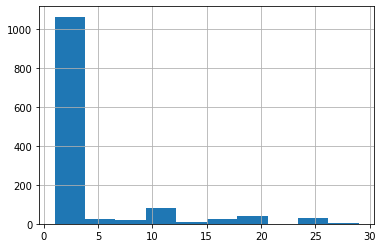

In [7]:
data.query('Price < 30')['Price'].hist(bins=10)

In [8]:
#убираем нулевые значения в целевом признаке
data['Price'].value_counts()

data = data.query('Price > 2')

In [9]:
data=data.dropna(subset=['Gearbox']).reset_index()


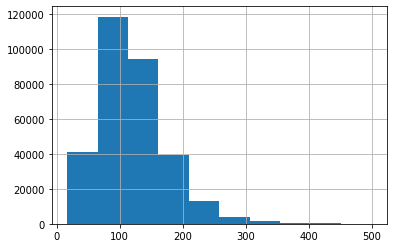

In [10]:
data['Power'].value_counts()

#убираем неадекватную мощность

power_1 = data[(data['Power'] < 2000) & (data['Power'] > 500)].index
data['Power'].loc[power_1] = data['Power'] / 10

power_2 = data[data['Power'] < 30].index
data['Power'].loc[power_2]=data.groupby(by=['Model', 'Brand'])['Power'].transform('mean')

power_3 = data[data['Power'] >=2000].index
data['Power'].loc[power_3] = data['Power'] / 100

data['Power'].hist()


In [11]:
 #замена пропущенных значений в столбце с мощностью по марке машины
data['Power'] = data['Power'].fillna(data.groupby(['Brand','Model'])['Power'].transform('median'))

In [12]:
#оставляем строки где модель не пропущена
data = data[data['Model'].notna()]

In [13]:
 #замена пропущенных значений в типе топлива
data['FuelType']=data['FuelType'].fillna('other')

In [14]:
 #замена пропущенных значений была ли машина в ремонте
data['NotRepaired']=data['NotRepaired'].fillna('no')

In [15]:
#удаление столбцов, которые не являются признаками

data.drop(['DateCrawled', 'DateCreated','PostalCode','LastSeen','NumberOfPictures'], axis=1, inplace=True)

## Обучение моделей

In [95]:
features = data.drop('Price', axis=1)
target = data['Price']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [96]:
model = CatBoostRegressor(loss_function="RMSE", iterations=100,random_seed=12345) 

cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired','type']


In [97]:
%%time

model.fit(features_train, target_train, cat_features=cat_features, verbose=10)


0:	learn: 4503.0431380	total: 188ms	remaining: 18.6s
10:	learn: 3682.9222791	total: 2.58s	remaining: 20.9s
20:	learn: 3117.1255430	total: 4.87s	remaining: 18.3s
30:	learn: 2725.1952863	total: 7.16s	remaining: 15.9s
40:	learn: 2447.5509017	total: 9.46s	remaining: 13.6s
50:	learn: 2250.7559067	total: 11.7s	remaining: 11.2s
60:	learn: 2119.0400075	total: 14s	remaining: 8.92s
70:	learn: 2013.4196801	total: 16.1s	remaining: 6.59s
80:	learn: 1941.9882649	total: 18.4s	remaining: 4.32s
90:	learn: 1888.4096716	total: 20.7s	remaining: 2.05s
99:	learn: 1850.2509689	total: 22.8s	remaining: 0us
CPU times: user 21.1 s, sys: 2.79 s, total: 23.9 s
Wall time: 25.4 s


In [99]:
%%time
prediction_valid=model.predict(features_valid)
print('RMSE=',mean_squared_error(target_valid,prediction_valid)**0.5 )

RMSE= 1862.9013485425576
CPU times: user 192 ms, sys: 9.05 ms, total: 201 ms
Wall time: 199 ms


In [72]:
data_ohe = pd.get_dummies(data, drop_first=True)

features_ohe = data_ohe.drop('Price', axis=1)
target_ohe = data_ohe['Price']

features_train, features_valid, target_train, target_valid = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)


In [73]:
%%time
rfr = RandomForestRegressor()
rfr.fit(features_train, target_train)


CPU times: user 59.2 s, sys: 247 ms, total: 59.4 s
Wall time: 59.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [74]:
%%time

prediction_valid=rfr.predict(features_valid)
print('RMSE=',mean_squared_error(target_valid,prediction_valid)**0.5 )

RMSE= 1547.5807143853372
CPU times: user 627 ms, sys: 53 ms, total: 680 ms
Wall time: 686 ms


In [75]:
%%time
model = LGBMRegressor(n_estimators = 50,random_state=12345)
model.fit(features_train, target_train)


CPU times: user 7.98 s, sys: 262 ms, total: 8.24 s
Wall time: 8.35 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [76]:
%%time

prediction_valid=model.predict(features_valid)
print('RMSE=',mean_squared_error(target_valid,prediction_valid)**0.5 )

RMSE= 1647.674233294552
CPU times: user 515 ms, sys: 93.7 ms, total: 608 ms
Wall time: 611 ms


In [77]:
%%time
model = LGBMRegressor(n_estimators = 150,max_depth=50, random_state=12345)
model.fit(features_train, target_train)


CPU times: user 14.2 s, sys: 308 ms, total: 14.5 s
Wall time: 14.7 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=50,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [78]:
%%time
prediction_valid=model.predict(features_valid)
print('RMSE=',mean_squared_error(target_valid,prediction_valid)**0.5 )

RMSE= 1531.0245500805947
CPU times: user 1.06 s, sys: 69.9 ms, total: 1.13 s
Wall time: 1.11 s


## Анализ моделей

In [52]:
results=pd.DataFrame({'Модель':['CatBoostRegressor','LGBMRegressor','RandomForestRegressor'],
                      'RMSe': ['1943', '1598', '1598'],
                       'Time,s fit ': ['24.2 s', '14.2 s', '1min 5s'],
                       'Time,s predict ': ['157 ms', '1.21 s', '768 ms']
                     }) 

print(results)

                  Модель  RMSe Time,s fit  Time,s predict 
0      CatBoostRegressor  1943      24.2 s          157 ms
1          LGBMRegressor  1598      14.2 s          1.21 s
2  RandomForestRegressor  1598     1min 5s          768 ms


Загрузила и подготовила данные для дальнейшего обучения. Обучила 3 разных модели, для этого использовала не только градиентный бустинг, но и простую модель, чтобы сравнить результаты. Для оценки качества моделей применяла метрику RMSE.

<b> Вывод:  </b>
Лучший результат, по соотношению время работы и качества показала модель Градиентного Бустинга LGBM, при подборе гиперпараметров. При этом значение RMSE у простой модели Случаного Леса одинаковое = 1598, но время затрачено больше. 



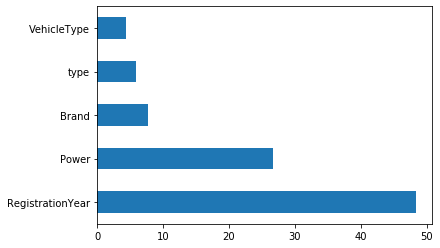

In [100]:
import matplotlib.pyplot as plt
import numpy as np



(pd.Series(model.feature_importances_, index=features_train.columns)
   .nlargest(5)
   .plot(kind='barh')) 